##### In this notebook we will be implementing the autoencoder model with simple neural networks.

In [119]:
import torch
import torch.nn as nn
from torchvision.datasets import MNIST
from torchvision.transforms import transforms
import numpy as np

In [120]:
# Set device to cuda 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

Device: cuda


In [121]:
# set up the transformations required for the training and testing data
# convert to tensor, normalize and move to cuda
image_transform = transforms.Compose([
    transforms.ToTensor(),transforms.Normalize([0.5], [0.5]),transforms.Lambda(lambda x : x.to(device))
])

In [122]:
# Creating training and testing datasets
train_dataset = MNIST(root='./MnistDataset', train=True, transform=image_transform, download=True)
validation_dataset = MNIST(root='./MnistDataset', train=False, transform=image_transform, download=True)

In [123]:
print('Training dataset size:', len(train_dataset))
print('Validation dataset size:', len(validation_dataset))

Training dataset size: 60000
Validation dataset size: 10000


In [124]:
# Set up the dataloaders
from torch.utils.data import DataLoader
batch_size = 256

trainLoader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validationLoader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

In [125]:
# Defining the network architecture
class AutoEncoder(nn.Module):
    def __init__(self,latent_dimension):
        super().__init__()
        
        self.latentDim = latent_dimension
        
        # define the encoder
        self.encoder = nn.Sequential(
            nn.Linear(28*28,128),
            nn.ReLU(True),
            nn.Linear(128,64),
            nn.ReLU(True),
            nn.Linear(64,latent_dimension)
        )
        
        # defining the decoder model
        self.decoder = nn.Sequential(
            nn.Linear(latent_dimension,64),
            nn.ReLU(True),
            nn.Linear(64,128),
            nn.ReLU(True),
            nn.Linear(128,28*28),
            nn.Tanh()
        )
    
    # forward pass
    def forward(self,x):
        x = x.view(len(x),-1)
        x = self.encoder(x)
        x = self.decoder(x)
        x = x.view(len(x),1,28,28)
        return x

In [126]:
# model summary
from torchsummary import summary
latentDim = 3
model = AutoEncoder(latentDim).to(device)
summary(model, torch.zeros(2,1,28,28).to(device))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 3]                   --
|    └─Linear: 2-1                       [-1, 128]                 100,480
|    └─ReLU: 2-2                         [-1, 128]                 --
|    └─Linear: 2-3                       [-1, 64]                  8,256
|    └─ReLU: 2-4                         [-1, 64]                  --
|    └─Linear: 2-5                       [-1, 3]                   195
├─Sequential: 1-2                        [-1, 784]                 --
|    └─Linear: 2-6                       [-1, 64]                  256
|    └─ReLU: 2-7                         [-1, 64]                  --
|    └─Linear: 2-8                       [-1, 128]                 8,320
|    └─ReLU: 2-9                         [-1, 128]                 --
|    └─Linear: 2-10                      [-1, 784]                 101,136
|    └─Tanh: 2-11                        [-1, 784]                 

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 3]                   --
|    └─Linear: 2-1                       [-1, 128]                 100,480
|    └─ReLU: 2-2                         [-1, 128]                 --
|    └─Linear: 2-3                       [-1, 64]                  8,256
|    └─ReLU: 2-4                         [-1, 64]                  --
|    └─Linear: 2-5                       [-1, 3]                   195
├─Sequential: 1-2                        [-1, 784]                 --
|    └─Linear: 2-6                       [-1, 64]                  256
|    └─ReLU: 2-7                         [-1, 64]                  --
|    └─Linear: 2-8                       [-1, 128]                 8,320
|    └─ReLU: 2-9                         [-1, 128]                 --
|    └─Linear: 2-10                      [-1, 784]                 101,136
|    └─Tanh: 2-11                        [-1, 784]                 

In [127]:
# Training batch
def trainBatch(input, model, criterion, optimiser):
    model.train()
    optimiser.zero_grad()
    output = model(input)
    loss = criterion(output, input)
    loss.backward()
    optimiser.step()
    return loss

In [128]:
# validation batch
@torch.no_grad()
def validBatch(input, model, criterion):
    model.eval()
    output = model(input)
    loss = criterion(output, input)
    return loss

In [129]:
# Define the optimiser and loss function
latenDim = 10
model = AutoEncoder(latentDim).to(device)
criterion = nn.MSELoss()
optimiser = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)

EPOCH: 0.030  trn_loss: 0.768  (0.14s - 45.89s remaining)

EPOCH: 1.000  val_loss: 0.193  trn_loss: 0.261  (4.46s - 40.16s remaining)
EPOCH: 2.000  val_loss: 0.163  trn_loss: 0.176  (8.79s - 35.15s remaining)
EPOCH: 3.000  val_loss: 0.154  trn_loss: 0.158  (13.13s - 30.63s remaining)
EPOCH: 4.000  val_loss: 0.148  trn_loss: 0.151  (17.44s - 26.16s remaining)
EPOCH: 5.000  val_loss: 0.145  trn_loss: 0.147  (21.75s - 21.75s remaining)
EPOCH: 6.000  val_loss: 0.143  trn_loss: 0.144  (26.11s - 17.40s remaining)
EPOCH: 7.000  val_loss: 0.141  trn_loss: 0.142  (30.44s - 13.05s remaining)
EPOCH: 8.000  val_loss: 0.140  trn_loss: 0.140  (34.82s - 8.70s remaining)
EPOCH: 9.000  val_loss: 0.139  trn_loss: 0.139  (39.24s - 4.36s remaining)
EPOCH: 10.000  val_loss: 0.137  trn_loss: 0.137  (43.57s - 0.00s remaining)


100%|██████████| 111/111 [00:00<00:00, 6407.04it/s]


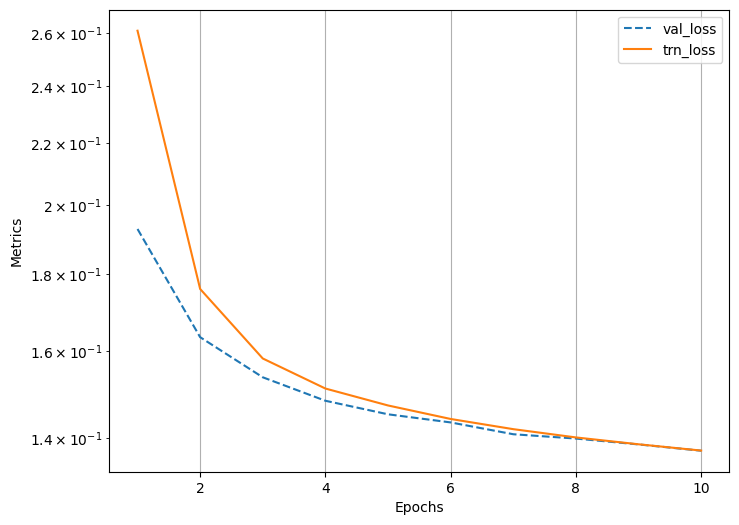

In [130]:
# Train model over increasing epochs
numEpochs = 10

# report
from torch_snippets import Report
log = Report(numEpochs)

for epoch in range(numEpochs):
    N = len(trainLoader)
    
    for index,(image,label) in enumerate(trainLoader):
        loss = trainBatch(image, model, criterion, optimiser)
        log.record(pos=(epoch + (index+1)/N), trn_loss=loss,end = '\r')
    
    N = len(validationLoader)
    for index,(image,label) in enumerate(validationLoader):
        loss = validBatch(image, model, criterion)
        log.record(pos=(epoch + (index+1)/N), val_loss=loss,end = '\r')
    
    log.report_avgs(epoch+1)
log.plot_epochs(log=True)

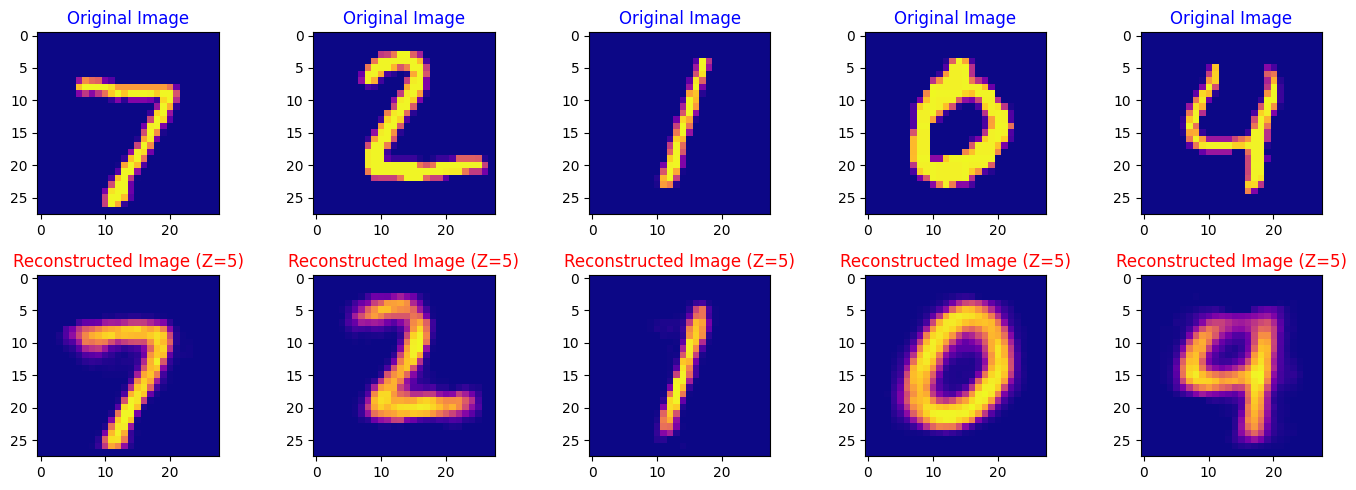

In [131]:
import matplotlib.pyplot as plt

# Create subplots with 2 rows and 5 columns, transposed
fig, axs = plt.subplots(2, 5, figsize=(14, 5))

# Iterate over 5 images in the validation set
for i in range(5):
    # Get the i-th image and send it to the device
    image, _ = validation_dataset[i]
    image = image.unsqueeze(0).to(device)
    
    # Generate the output using the model
    output = model(image)
    
    # Plot the original image
    axs[0, i].imshow(image.cpu().numpy().squeeze(), cmap='plasma')
    axs[0, i].set_title('Original Image', fontsize=12, color='blue')
    
    # Plot the reconstructed image
    axs[1, i].imshow(output.cpu().detach().numpy().squeeze(), cmap='plasma')
    axs[1, i].set_title('Reconstructed Image (Z=5)', fontsize=12, color='red')

# Adjust vertical spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()
